In [2]:
import pandas as pd

df = pd.read_csv("raw_kg.tsv.gz", sep="\t", compression="gzip")

print(df.head())

      x_id x_type    x_name  x_source            y_id   y_type  \
0    93611   Gene    FBXO44      NCBI  UBERON:0000082  Anatomy   
1    53343   Gene     NUDT9      NCBI  UBERON:0001302  Anatomy   
2   219793   Gene     TBATA      NCBI  UBERON:0001225  Anatomy   
3  DB00682   Drug  Warfarin  DrugBank         DB09073     Drug   
4     9732   Gene     DOCK4      NCBI  UBERON:0002167  Anatomy   

                   y_name  y_source       relation         display_relation  \
0  adult mammalian kidney    UBERON      ExpressIN   Gene_ExpressIN_Anatomy   
1      right uterine tube    UBERON      ExpressIN   Gene_ExpressIN_Anatomy   
2        cortex of kidney    UBERON  LowExpression  Gene_LowExpress_Anatomy   
3             Palbociclib  DrugBank            DDI    Drug_Drug_Interaction   
4              right lung    UBERON      ExpressIN   Gene_ExpressIN_Anatomy   

  rel_source  
0       Bgee  
1       Bgee  
2       Bgee  
3   DrugBank  
4       Bgee  


In [3]:
df['relation'].value_counts()

relation
ExpressIN                                     2900693
DDI                                           2866522
CelllinedependOnGene                          2181796
SL                                            1809140
PPI                                            581559
miRNAtargetsGene                               412550
LigandBindsProtein                             331324
PhenoPres                                      149945
NONSL                                          112246
HighExpression                                 107541
LowExpression                                   99787
GenedamgemutinCellling                          99631
involved_in                                     78991
DrugEffect                                      76183
is_a                                            66810
AssociatdeWith                                  60102
enables                                         54467
Reactome                                        45184
located_in         

In [4]:
filtered_df = df[df['display_relation'].isin(['Gene_SL_Gene', 'Gene_NONSL_Gene'])]
filtered_df

,x_id,x_type,x_name,x_source,y_id,y_type,y_name,y_source,relation,display_relation,rel_source
21,5440,Gene,POLR2K,NCBI,30834,Gene,POLR1H,NCBI,NONSL,Gene_NONSL_Gene,High Throughput
23,1576,Gene,CYP3A4,NCBI,84310,Gene,C7orf50,NCBI,SL,Gene_SL_Gene,GCATSL;KG4SL
31,25862,Gene,USP49,NCBI,81876,Gene,RAB1B,NCBI,SL,Gene_SL_Gene,NSF4SL
37,80820,Gene,EEPD1,NCBI,284532,Gene,OR14A16,NCBI,SL,Gene_SL_Gene,SL2MF
38,207,Gene,AKT1,NCBI,6223,Gene,RPS19,NCBI,SL,Gene_SL_Gene,DDGCN;NSF4SL
...,...,...,...,...,...,...,...,...,...,...,...
12278422,1441,Gene,CSF3R,NCBI,23560,Gene,GTPBP4,NCBI,SL,Gene_SL_Gene,GRSMF;PTGNN;DDGCN
12278431,5428,Gene,POLG,NCBI,2967,Gene,GTF2H3,NCBI,SL,Gene_SL_Gene,SLMGAE
12278432,3014,Gene,H2AX,NCBI,6647,Gene,SOD1,NCBI,SL,Gene_SL_Gene,SL2MF;SLGNN;NSF4SL
12278433,5742,Gene,PTGS1,NCBI,89801,Gene,PPP1R3F,NCBI,SL,Gene_SL_Gene,KG4SL;SLGNN;GCATSL;PTGNN


In [5]:
triples_df = filtered_df[['x_name', 'display_relation', 'y_name']]
triples_df.columns = ['head', 'relation', 'tail']
triples_path = "triples.tsv"
triples_df.to_csv(triples_path, sep="\t", index=False, header=False)

In [6]:
# Calculate the number of unique nodes (head + tail)
unique_nodes = set(triples_df['head']).union(set(triples_df['tail']))
num_nodes = len(unique_nodes)

# Calculate the number of edges (rows in triples_df)
num_edges = len(triples_df)

print(f"Number of Nodes: {num_nodes}")
print(f"Number of Edges: {num_edges}")


Number of Nodes: 12145
Number of Edges: 1921386


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

# Assuming triples_df is your DataFrame with the 'head', 'relation', and 'tail' columns
# Create an undirected graph
G = nx.Graph()

# Add nodes and edges to the graph
for idx, row in triples_df.iterrows():
    head, tail, relation = row['head'], row['tail'], row['relation']
    G.add_node(head)  # Add head node
    G.add_node(tail)  # Add tail node
    G.add_edge(head, tail, relation=relation)  # Add edge with relation as an attribute

# Draw the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)  # Positions for all nodes

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')

# Draw edges
nx.draw_networkx_edges(G, pos, width=2, alpha=0.5, edge_color='gray')

# Draw labels for nodes
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

# Draw edge labels (relations)
edge_labels = nx.get_edge_attributes(G, 'relation')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Gene Relation Network")
plt.axis("off")  # Hide axes
plt.show()


In [6]:
import torch
from sklearn.model_selection import train_test_split
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory
import pandas as pd

# Load the triples data from the file (assuming your file is in tab-separated format)
triples_path = 'triples.tsv'  # Replace with your actual triples file path
triples_df = pd.read_csv(triples_path, sep="\t", names=["head", "relation", "tail"])

# === Step 1: Stratified Split by Relation ===
# Split the triples dataframe into train, validation, and test using stratified sampling
train_df, temp_df = train_test_split(
    triples_df, test_size=0.2, stratify=triples_df['relation'], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['relation'], random_state=42
)

# === Step 2: Convert DataFrames to TriplesFactory ===
train_tf = TriplesFactory.from_labeled_triples(train_df.values)
val_tf = TriplesFactory.from_labeled_triples(val_df.values)
test_tf = TriplesFactory.from_labeled_triples(test_df.values)

# === Step 3: Define and Run the Pipeline ===
result_rgcn = pipeline(
    training=train_tf,
    validation=val_tf,
    testing=test_tf,
    model="RGCN",  # R-GCN uses message passing to update entity representations
    training_kwargs={"num_epochs": 10}
)

# Get the trained model and entity embeddings
trained_model_rgcn = result_rgcn.model
entity_embeddings_rgcn = trained_model_rgcn.entity_representations[0]()  # Final entity representations

# Print the entity embeddings
print("Entity embeddings from R-GCN:")
print(entity_embeddings_rgcn)


No random seed is specified. Setting to 1200694592.
Layers RGCNLayer(
  (fwd): BasesDecomposition(
    (relation_representations): LowRankRepresentation(
      (bases): Embedding(
        (_embeddings): Embedding(2, 250000)
      )
    )
  )
  (bwd): BasesDecomposition(
    (relation_representations): LowRankRepresentation(
      (bases): Embedding(
        (_embeddings): Embedding(2, 250000)
      )
    )
  )
  (self_loop): Linear(in_features=500, out_features=500, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) has parameters, but no reset_parameters.
Layers RGCNLayer(
  (fwd): BasesDecomposition(
    (relation_representations): LowRankRepresentation(
      (bases): Embedding(
        (_embeddings): Embedding(2, 250000)
      )
    )
  )
  (bwd): BasesDecomposition(
    (relation_representations): LowRankRepresentation(
      (bases): Embedding(
        (_embeddings): Embedding(2, 250000)
      )
    )
  )
  (self_loop): Linear(in_features=500, out_features=500, bias=True)
  

Training epochs on cuda:0:   0%|          | 0/10 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/6001 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/6001 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/6001 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/6001 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/6001 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/6001 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/6001 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/6001 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/6001 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/6001 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/192k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 92.16s seconds


Entity embeddings from R-GCN:
tensor([[ 0.1231, -1.1282,  0.3839,  ..., -2.2008, -0.2724,  0.7941],
        [ 0.6538, -0.7737, -1.0992,  ..., -0.0624,  0.4732, -1.7049],
        [ 0.9373, -0.3991, -0.8106,  ..., -0.3492,  0.0123, -0.6206],
        ...,
        [ 1.5512, -1.0935, -0.2198,  ..., -1.1727,  1.4353, -0.0958],
        [ 0.4194,  0.6772,  0.7545,  ..., -2.7525, -0.7963,  0.0356],
        [ 1.6198, -1.9741, -1.6380,  ..., -0.8544,  1.7557, -0.9384]],
       device='cuda:0')


In [7]:
# === Print Entity Embeddings ===
print("Printing all Entity Embeddings:")
print(entity_embeddings_rgcn)  # This prints the entire tensor (beware of large output)

# If the tensor is too large, you can print only a subset or summary statistics:
print("Summary of Entity Embeddings:")
print(f"Shape of embeddings: {entity_embeddings_rgcn.shape}")
print(f"First 5 embeddings:\n{entity_embeddings_rgcn[:5]}")  # Print the first 5 embeddings

# === Print the Model Architecture ===
print("\nModel Architecture:")
print(trained_model_rgcn)

# === Print the Model's Parameters ===
print("\nModel Parameters (Weights):")
for name, param in trained_model_rgcn.named_parameters():
    print(f"{name}: {param.shape}")
    print(param.data[:5])  # Print the first 5 elements of each parameter tensor for inspection


Printing all Entity Embeddings:
tensor([[ 0.1231, -1.1282,  0.3839,  ..., -2.2008, -0.2724,  0.7941],
        [ 0.6538, -0.7737, -1.0992,  ..., -0.0624,  0.4732, -1.7049],
        [ 0.9373, -0.3991, -0.8106,  ..., -0.3492,  0.0123, -0.6206],
        ...,
        [ 1.5512, -1.0935, -0.2198,  ..., -1.1727,  1.4353, -0.0958],
        [ 0.4194,  0.6772,  0.7545,  ..., -2.7525, -0.7963,  0.0356],
        [ 1.6198, -1.9741, -1.6380,  ..., -0.8544,  1.7557, -0.9384]],
       device='cuda:0')
Summary of Entity Embeddings:
Shape of embeddings: torch.Size([11847, 500])
First 5 embeddings:
tensor([[ 0.1231, -1.1282,  0.3839,  ..., -2.2008, -0.2724,  0.7941],
        [ 0.6538, -0.7737, -1.0992,  ..., -0.0624,  0.4732, -1.7049],
        [ 0.9373, -0.3991, -0.8106,  ..., -0.3492,  0.0123, -0.6206],
        [ 2.3547,  0.3840, -0.3028,  ..., -0.0865, -0.8517,  1.2909],
        [ 1.7662, -0.2427,  0.0234,  ..., -0.9658,  0.6781,  0.2513]],
       device='cuda:0')

Model Architecture:
RGCN(
  (loss): Ma

/tmp/ipykernel_95808/550611317.py:22: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(pca_result[:, 0], pca_result[:, 1], c='blue', cmap='viridis', s=50, alpha=0.6)


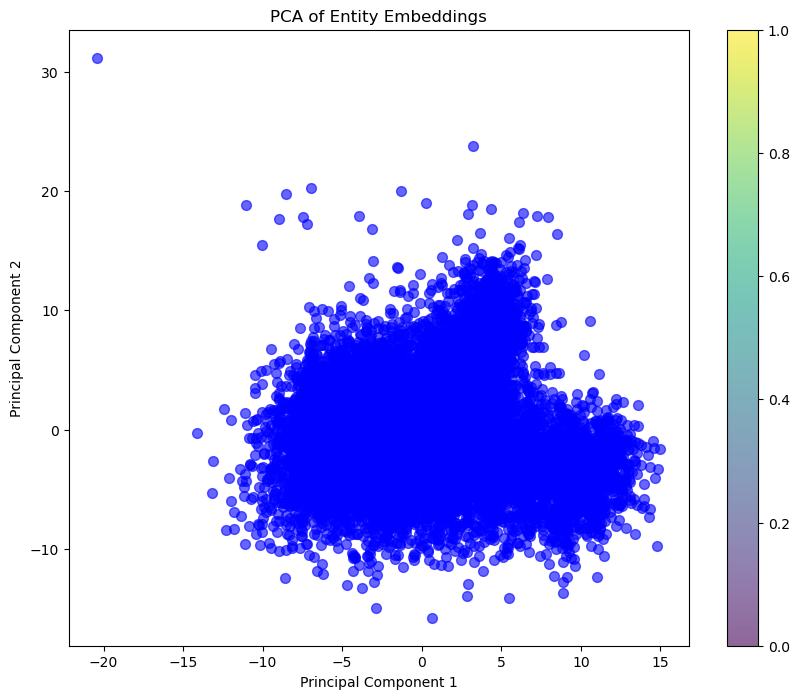

/tmp/ipykernel_95808/550611317.py:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c='green', cmap='viridis', s=50, alpha=0.6)


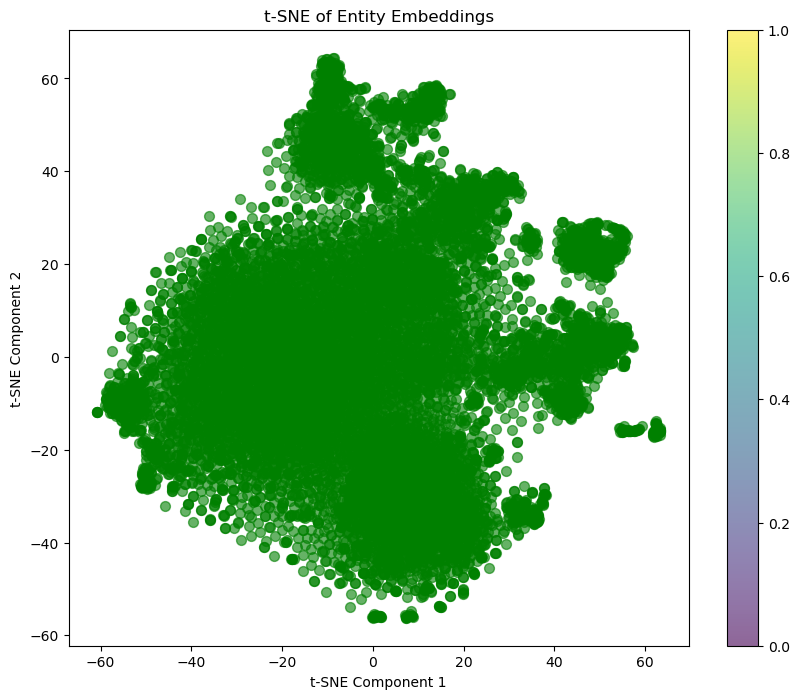

Silhouette Score after clustering: 0.013407356105744839


In [8]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import seaborn as sns
import numpy as np

# Step 1: Ensure entity_embeddings_rgcn is on CPU and in NumPy format for further analysis
entity_embeddings_np = entity_embeddings_rgcn.detach().cpu().numpy()  # Convert to NumPy array

# Step 2: Perform PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(entity_embeddings_np)

# Step 3: Perform t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(entity_embeddings_np)

# Step 4: Plot the PCA result
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='blue', cmap='viridis', s=50, alpha=0.6)
plt.title('PCA of Entity Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

# Step 5: Plot the t-SNE result
plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c='green', cmap='viridis', s=50, alpha=0.6)
plt.title('t-SNE of Entity Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar()
plt.show()

# Step 6: Apply KMeans clustering for Silhouette Score Calculation
# Perform clustering using KMeans to create clusters
kmeans = KMeans(n_clusters=5, random_state=42)  # Choose the number of clusters (5 in this case)
cluster_labels = kmeans.fit_predict(entity_embeddings_np)

# Step 7: Calculate the Silhouette Score
sil_score = silhouette_score(entity_embeddings_np, cluster_labels)
print(f"Silhouette Score after clustering: {sil_score}")


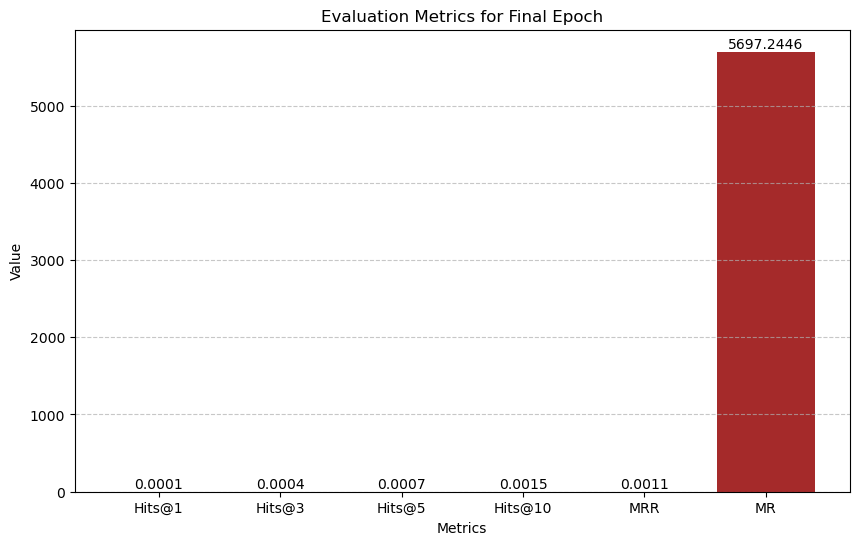

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract evaluation metrics from result.metric_results
metric_results = result_rgcn.metric_results

# Extracting Hits@k values
hits_at_1 = metric_results.get_metric('hits_at_1')
hits_at_3 = metric_results.get_metric('hits_at_3')
hits_at_5 = metric_results.get_metric('hits_at_5')
hits_at_10 = metric_results.get_metric('hits_at_10')

# Extracting MRR and MR
mrr = metric_results.get_metric('mean_reciprocal_rank')
mr = metric_results.get_metric('mean_rank')

# Create lists for metrics and labels
metrics_values = [hits_at_1, hits_at_3, hits_at_5, hits_at_10, mrr, mr]
labels = ['Hits@1', 'Hits@3', 'Hits@5', 'Hits@10', 'MRR', 'MR']

# Plotting the metrics as a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, metrics_values, color=['blue', 'green', 'orange', 'red', 'purple', 'brown'])

# Annotate the value on top of each bar
for bar, value in zip(bars, metrics_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.4f}',
             ha='center', va='bottom', fontsize=10, color='black')

# Labels, title, and grid
plt.xlabel("Metrics")
plt.ylabel("Value")
plt.title("Evaluation Metrics for Final Epoch")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()



In [16]:
import torch
from sklearn.model_selection import train_test_split
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory
import pandas as pd

# Load the triples data from the file (assuming your file is in tab-separated format)
triples_path = 'triples.tsv'  # Replace with your actual triples file path
triples_df = pd.read_csv(triples_path, sep="\t", names=["head", "relation", "tail"])

# === Step 1: Stratified Split by Relation ===
# Split the triples dataframe into train, validation, and test using stratified sampling
train_df, temp_df = train_test_split(
    triples_df, test_size=0.2, stratify=triples_df['relation'], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['relation'], random_state=42
)

# === Step 2: Convert DataFrames to TriplesFactory with Inverse Triples ===
train_tf = TriplesFactory.from_labeled_triples(train_df.values, create_inverse_triples=True)
val_tf = TriplesFactory.from_labeled_triples(val_df.values, create_inverse_triples=True)
test_tf = TriplesFactory.from_labeled_triples(test_df.values, create_inverse_triples=True)

# === Step 3: Define and Run the Pipeline ===
result_CompGCN = pipeline(
    training=train_tf,
    validation=val_tf,
    testing=test_tf,
    model="CompGCN",  # CompGCN uses message passing to update entity representations
    training_kwargs={"num_epochs": 1}
)

# Get the trained model and entity embeddings
trained_model_compgcn = result_CompGCN.model  # Use the correct result name
entity_embeddings_compgcn = trained_model_compgcn.entity_representations[0]()  # Final entity representations

# Print the entity embeddings
print("Entity embeddings from CompGCN:")
print(entity_embeddings_compgcn)



INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training epochs on cuda:0:   0%|          | 0/1 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.
INFO:pykeen.training.training_loop:Dropping last (incomplete) batch each epoch (1/12001 (0.01%) batches).


Training batches on cuda:0:   0%|          | 0/12001 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/192k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 62.66s seconds


Entity embeddings from CompGCN:
tensor([[-7.9441e-01,  1.6038e-01,  1.0736e+00,  ...,  1.2628e-02,
         -9.6927e-04,  6.2821e-02],
        [-8.4188e-01,  5.2242e-01,  1.2318e+00,  ...,  3.9641e-01,
          2.3327e-01, -1.7641e-01],
        [-5.7935e-01,  3.5385e-01,  1.0468e+00,  ...,  3.2439e-02,
          1.0050e-01,  8.5284e-02],
        ...,
        [ 1.0056e+00,  2.7265e-01,  1.5020e+00,  ..., -1.6814e-01,
          1.3095e+00, -3.7695e-01],
        [-8.3368e-01,  1.3025e-01,  1.0729e+00,  ..., -1.1272e-02,
         -3.2857e-02,  4.4641e-02],
        [-7.0886e-01,  1.3448e-01,  1.1940e+00,  ..., -2.8064e-01,
          1.2316e-01,  1.1325e-02]], device='cuda:0')


/tmp/ipykernel_95808/3820423079.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(pca_result[:, 0], pca_result[:, 1], c='blue', cmap='viridis', s=50, alpha=0.6)


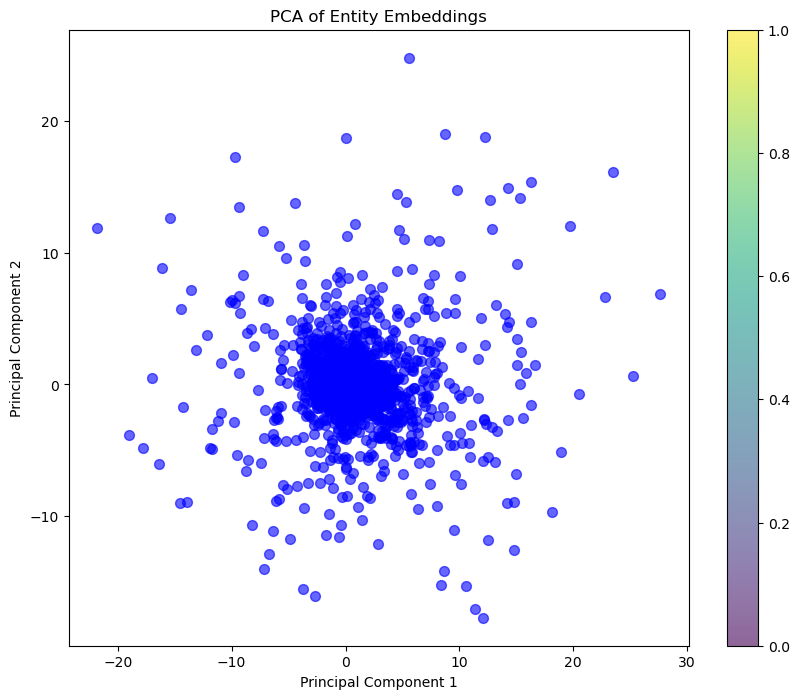

/tmp/ipykernel_95808/3820423079.py:22: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c='green', cmap='viridis', s=50, alpha=0.6)


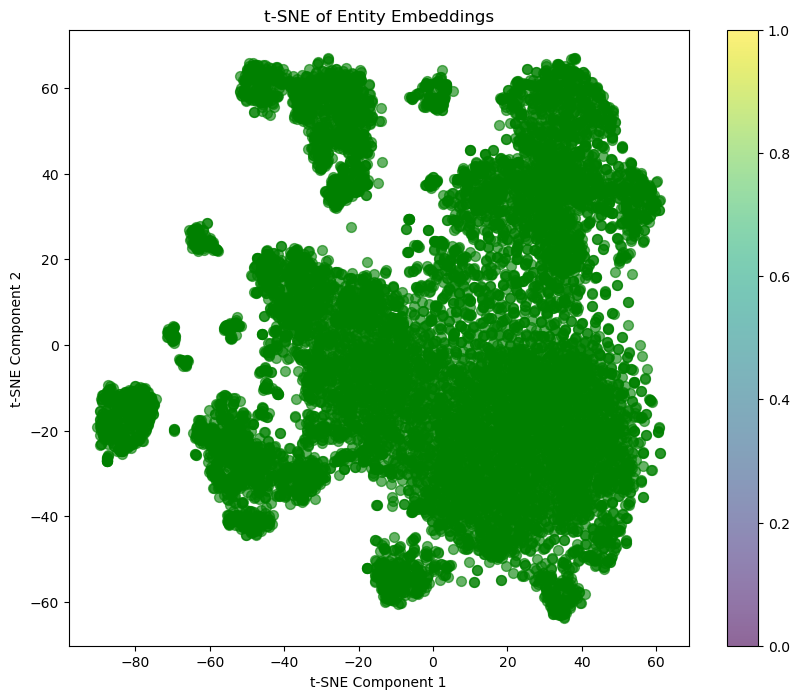

Silhouette Score after clustering: 0.11570508033037186


In [17]:
entity_embeddings_np = entity_embeddings_compgcn.detach().cpu().numpy()  # Convert to NumPy array

# Step 2: Perform PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(entity_embeddings_np)

# Step 3: Perform t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(entity_embeddings_np)

# Step 4: Plot the PCA result
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='blue', cmap='viridis', s=50, alpha=0.6)
plt.title('PCA of Entity Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

# Step 5: Plot the t-SNE result
plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c='green', cmap='viridis', s=50, alpha=0.6)
plt.title('t-SNE of Entity Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar()
plt.show()

# Step 6: Apply KMeans clustering for Silhouette Score Calculation
# Perform clustering using KMeans to create clusters
kmeans = KMeans(n_clusters=5, random_state=42)  # Choose the number of clusters (5 in this case)
cluster_labels = kmeans.fit_predict(entity_embeddings_np)

# Step 7: Calculate the Silhouette Score
sil_score = silhouette_score(entity_embeddings_np, cluster_labels)
print(f"Silhouette Score after clustering: {sil_score}")


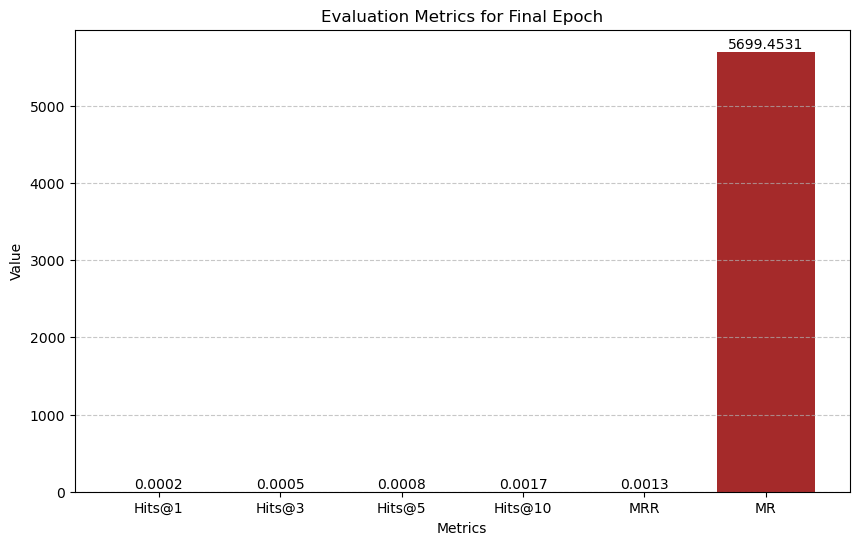

In [18]:
# Extract evaluation metrics from result.metric_results
metric_results = result_CompGCN.metric_results

# Extracting Hits@k values
hits_at_1 = metric_results.get_metric('hits_at_1')
hits_at_3 = metric_results.get_metric('hits_at_3')
hits_at_5 = metric_results.get_metric('hits_at_5')
hits_at_10 = metric_results.get_metric('hits_at_10')

# Extracting MRR and MR
mrr = metric_results.get_metric('mean_reciprocal_rank')
mr = metric_results.get_metric('mean_rank')

# Create lists for metrics and labels
metrics_values = [hits_at_1, hits_at_3, hits_at_5, hits_at_10, mrr, mr]
labels = ['Hits@1', 'Hits@3', 'Hits@5', 'Hits@10', 'MRR', 'MR']

# Plotting the metrics as a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, metrics_values, color=['blue', 'green', 'orange', 'red', 'purple', 'brown'])

# Annotate the value on top of each bar
for bar, value in zip(bars, metrics_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.4f}',
             ha='center', va='bottom', fontsize=10, color='black')

# Labels, title, and grid
plt.xlabel("Metrics")
plt.ylabel("Value")
plt.title("Evaluation Metrics for Final Epoch")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


In [22]:
#!pip install bioontologies
#!pip install pyobo
!pip install pykeen[transformers]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 23.9 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.7/781.7 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 32.4 MB/s eta 0:00:00


In [34]:
# print(triples_df.isnull().sum()) 
# # Create TriplesFactory objects
# train_tf = TriplesFactory.from_labeled_triples(train_df.values)
# val_tf = TriplesFactory.from_labeled_triples(val_df.values)
# test_tf = TriplesFactory.from_labeled_triples(test_df.values)

# Check if the TriplesFactory objects are valid
print(f"Train TriplesFactory: {train_tf}")
print(f"Validation TriplesFactory: {val_tf}")
print(f"Test TriplesFactory: {test_tf}")
train_tf = TriplesFactory.from_labeled_triples(
    triples=train_df.values,
    create_inverse_triples=False,  # Important: don't create inverse triples which might lose labels
)
# Debug: print the first few triples and entity labels
print("First 5 triples:", triples_df.head(5).values)
print("Entity labels from TriplesFactory:", train_tf.entity_labels)


Train TriplesFactory: TriplesFactory(num_entities=11847, num_relations=2, create_inverse_triples=False, num_triples=1536245)
Validation TriplesFactory: TriplesFactory(num_entities=10281, num_relations=2, create_inverse_triples=False, num_triples=192125)
Test TriplesFactory: TriplesFactory(num_entities=10320, num_relations=2, create_inverse_triples=False, num_triples=192122)
First 5 triples: [['POLR2K' 'Gene_NONSL_Gene' 'POLR1H']
 ['CYP3A4' 'Gene_SL_Gene' 'C7orf50']
 ['USP49' 'Gene_SL_Gene' 'RAB1B']
 ['EEPD1' 'Gene_SL_Gene' 'OR14A16']
 ['AKT1' 'Gene_SL_Gene' 'RPS19']]


AttributeError: 'TriplesFactory' object has no attribute 'entity_labels'

## 1.Biomedical Entities

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from pykeen.triples import TriplesFactory
from pykeen.models import ERModel
from pykeen.nn import BiomedicalCURIERepresentation
from pykeen.pipeline import pipeline
from pykeen.datasets import Dataset

# === Data Loading and Splitting ===
triples_path = 'triples.tsv'  # Replace with your actual triples file path
triples_df = pd.read_csv(triples_path, sep="\t", names=["head", "relation", "tail"])
# Remove any rows with missing values in the triples
triples_df = triples_df.dropna(subset=["head", "relation", "tail"])

def convert_to_curies(triples_df):
    # Create a mapping dictionary
    gene_to_curie = {}
    
    # Simple approach: just add a prefix
    for gene in set(triples_df['head'].tolist() + triples_df['tail'].tolist()):
        gene_to_curie[gene] = f"GENE:{gene}"
    
    # Apply the mapping
    mapped_triples = triples_df.copy()
    mapped_triples['head'] = mapped_triples['head'].map(gene_to_curie)
    mapped_triples['tail'] = mapped_triples['tail'].map(gene_to_curie)
    
    return mapped_triples

# Convert genes to CURIEs first
curie_triples_df = convert_to_curies(triples_df)

# Now use the curie_triples_df for the train/test split
train_df, temp_df = train_test_split(
    curie_triples_df, test_size=0.34, stratify=curie_triples_df['relation'], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['relation'], random_state=42
)

# Convert DataFrames to TriplesFactory objects with the CURIE identifiers
train_tf = TriplesFactory.from_labeled_triples(train_df.values, create_inverse_triples=False)
val_tf = TriplesFactory.from_labeled_triples(val_df.values, create_inverse_triples=False)
test_tf = TriplesFactory.from_labeled_triples(test_df.values, create_inverse_triples=False)

# Create dataset
dataset = Dataset.from_tf(train_tf)
dataset.validation = val_tf
dataset.testing = test_tf

# Now the BiomedicalCURIERepresentation should work
entity_representations = BiomedicalCURIERepresentation.from_dataset(
    dataset=dataset,  
    encoder="transformer",
    missing_action="blank"  # Add this as a fallback for any entities that still don't have proper CURIEs
)

result_transe = pipeline(
    dataset=dataset,
    model="TransE",
    training_kwargs={"num_epochs": 50, "use_tqdm": True},
    model_kwargs=dict(
        entity_representations=entity_representations,
        embedding_dim=768,  # Match the dimension with entity representations
    ),
)

trained_model_transe = result_transe.model
# Get the final entity embeddings
entity_embeddings_transe = trained_model_transe.entity_representations[0]()

print("Entity embeddings from TransE:")
print(entity_embeddings_transe)

using automatically assigned random_state=1204466965
Prefix not registered in the Bioregistry: GENE


0it [00:00, ?it/s]

No random seed is specified. Setting to 536951889.


Training epochs on cuda:0:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/3962 [00:00<?, ?batch/s]

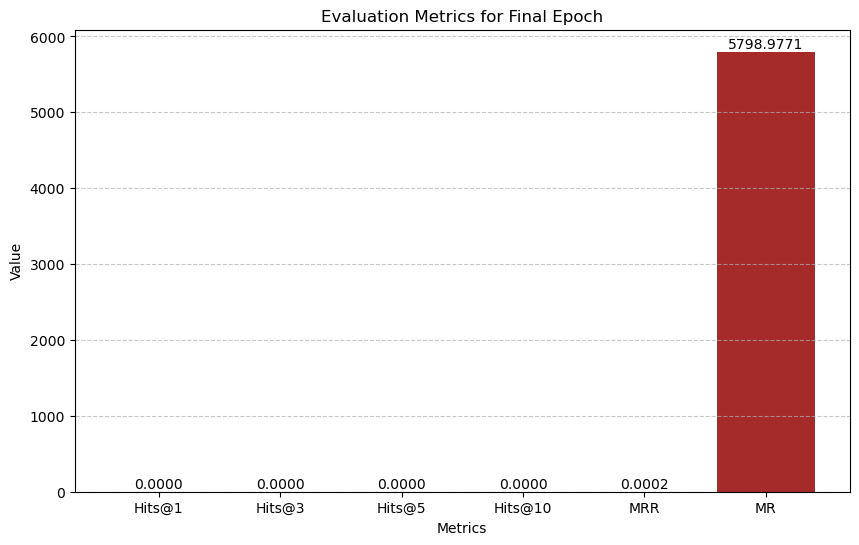

In [42]:
# Extract evaluation metrics from result.metric_results
metric_results = result_transe.metric_results

# Extracting Hits@k values
hits_at_1 = metric_results.get_metric('hits_at_1')
hits_at_3 = metric_results.get_metric('hits_at_3')
hits_at_5 = metric_results.get_metric('hits_at_5')
hits_at_10 = metric_results.get_metric('hits_at_10')

# Extracting MRR and MR
mrr = metric_results.get_metric('mean_reciprocal_rank')
mr = metric_results.get_metric('mean_rank')

# Create lists for metrics and labels
metrics_values = [hits_at_1, hits_at_3, hits_at_5, hits_at_10, mrr, mr]
labels = ['Hits@1', 'Hits@3', 'Hits@5', 'Hits@10', 'MRR', 'MR']

# Plotting the metrics as a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, metrics_values, color=['blue', 'green', 'orange', 'red', 'purple', 'brown'])

# Annotate the value on top of each bar
for bar, value in zip(bars, metrics_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.4f}',
             ha='center', va='bottom', fontsize=10, color='black')

# Labels, title, and grid
plt.xlabel("Metrics")
plt.ylabel("Value")
plt.title("Evaluation Metrics for Final Epoch")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

/tmp/ipykernel_389736/2575598068.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(pca_result[:, 0], pca_result[:, 1], c='blue', cmap='viridis', s=50, alpha=0.6)


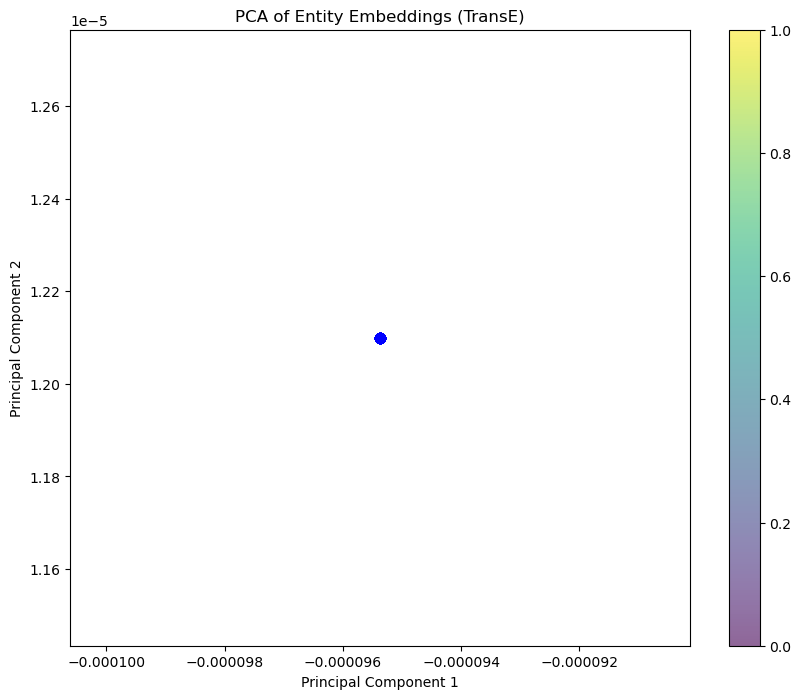

/tmp/ipykernel_389736/2575598068.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c='green', cmap='viridis', s=50, alpha=0.6)


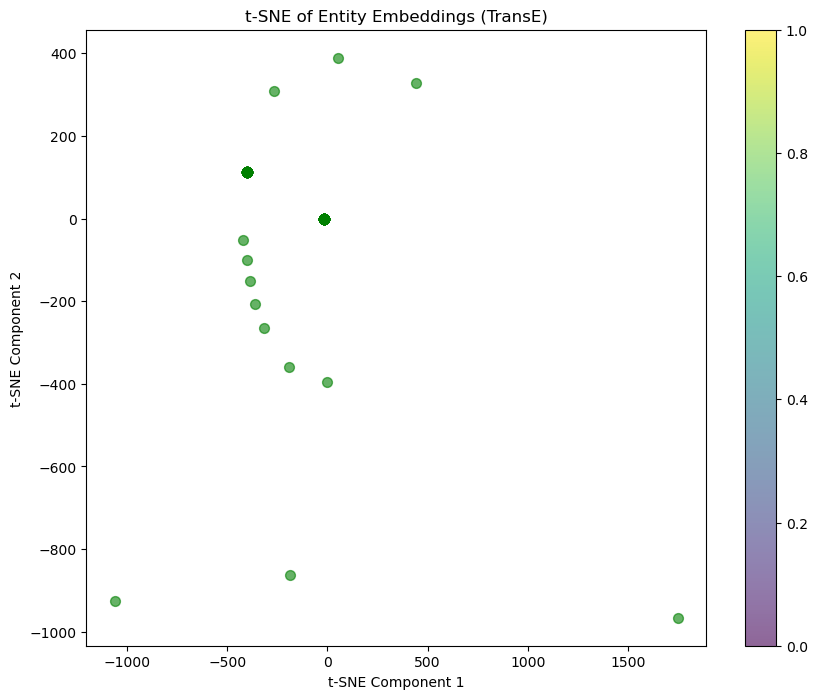

/home/aman24012/miniconda3/envs/aman-24012/lib/python3.10/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [43]:
# Step 1: Convert entity embeddings to a NumPy array for further analysis
entity_embeddings_np = entity_embeddings_transe.detach().cpu().numpy()

# Step 2: Perform PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(entity_embeddings_np)

# Step 3: Perform t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(entity_embeddings_np)

# Step 4: Plot the PCA result
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='blue', cmap='viridis', s=50, alpha=0.6)
plt.title('PCA of Entity Embeddings (TransE)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

# Step 5: Plot the t-SNE result
plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c='green', cmap='viridis', s=50, alpha=0.6)
plt.title('t-SNE of Entity Embeddings (TransE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar()
plt.show()

# Step 6: Apply KMeans clustering for Silhouette Score Calculation
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(entity_embeddings_np)

# Step 7: Calculate the Silhouette Score
sil_score = silhouette_score(entity_embeddings_np, cluster_labels)
print(f"Silhouette Score after clustering: {sil_score}")

# === Optional: Print Model Architecture and Parameters ===
print("\nModel Architecture:")
print(trained_model_transe)

print("\nModel Parameters (Weights):")
for name, param in trained_model_transe.named_parameters():
    print(f"{name}: {param.shape}")
    print(param.data[:5])  # Display first 5 elements of each parameter tensor


/home/aman24012/miniconda3/envs/aman-24012/lib/python3.10/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/aman24012/miniconda3/envs/aman-24012/lib/python3.10/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/aman24012/miniconda3/envs/aman-24012/lib/python3.10/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/aman24012/miniconda3/envs/aman-24012/lib/python3.10/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to

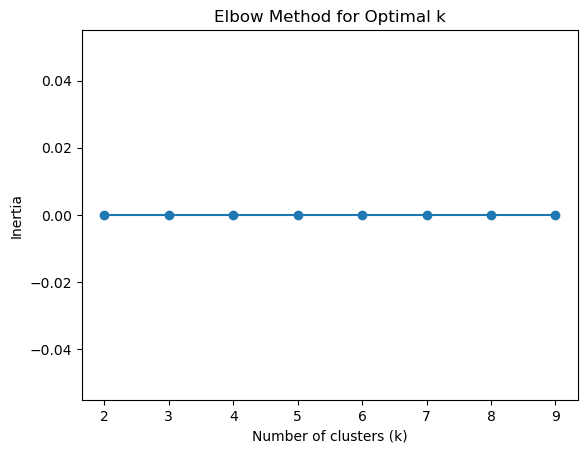

In [45]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Range of k values to test
k_range = range(2, 10)
inertia = []

# Compute KMeans for different k values
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(entity_embeddings_np)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()



(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>,
        <Axes: title={'center': 'Entity/Relation Plot using PCA'}>],
       dtype=object))

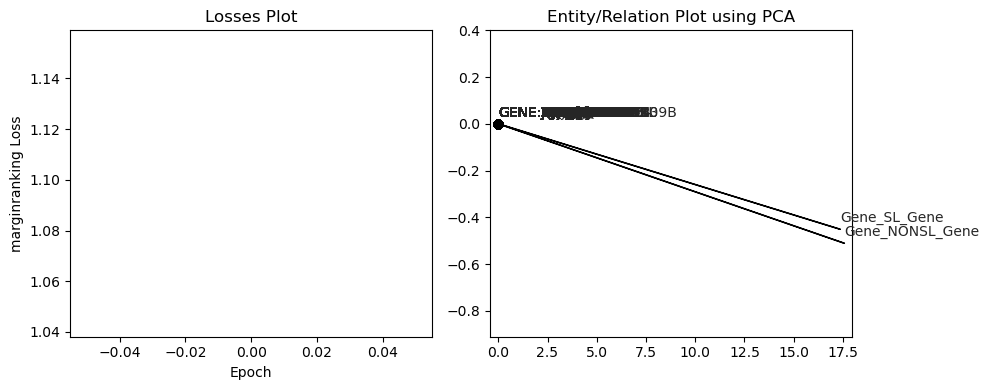

In [46]:
result_transe.plot()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Check the embedding distribution
embeddings = entity_embeddings_transe.detach().cpu().numpy()  # Ensure it's on CPU and in NumPy format
plt.hist(embeddings.flatten(), bins=100)  # Flatten embeddings for a histogram
plt.title("Embedding Distribution")
plt.xlabel("Embedding values")
plt.ylabel("Frequency")
plt.show()


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Example: Get cosine similarity between first two entities (for demonstration purposes)
entity_1 = embeddings[0]
entity_2 = embeddings[1]

cosine_sim = cosine_similarity([entity_1], [entity_2])
print(f"Cosine similarity between first two embeddings: {cosine_sim[0][0]}")


In [ ]:
from sklearn.cluster import KMeans

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)  # Assuming 2 relations
kmeans.fit(embeddings)
labels = kmeans.labels_

# Visualize clusters
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='viridis')
plt.title("KMeans Clustering of Entity Embeddings")
plt.show()


In [ ]:
## pairRE with BioCURIE

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from pykeen.triples import TriplesFactory
from pykeen.models import ERModel
from pykeen.nn import BiomedicalCURIERepresentation
from pykeen.pipeline import pipeline
from pykeen.datasets import Dataset

# === Data Loading and Splitting ===
triples_path = 'triples.tsv'  # Replace with your actual triples file path
triples_df = pd.read_csv(triples_path, sep="\t", names=["head", "relation", "tail"])
# Remove any rows with missing values in the triples
triples_df = triples_df.dropna(subset=["head", "relation", "tail"])

def convert_to_curies(triples_df):
    # Create a mapping dictionary
    gene_to_curie = {}
    
    # Simple approach: just add a prefix
    for gene in set(triples_df['head'].tolist() + triples_df['tail'].tolist()):
        gene_to_curie[gene] = f"GENE:{gene}"
    
    # Apply the mapping
    mapped_triples = triples_df.copy()
    mapped_triples['head'] = mapped_triples['head'].map(gene_to_curie)
    mapped_triples['tail'] = mapped_triples['tail'].map(gene_to_curie)
    
    return mapped_triples

# Convert genes to CURIEs first
curie_triples_df = convert_to_curies(triples_df)

# Now use the curie_triples_df for the train/test split
train_df, temp_df = train_test_split(
    curie_triples_df, test_size=0.34, stratify=curie_triples_df['relation'], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['relation'], random_state=42
)

# Convert DataFrames to TriplesFactory objects with the CURIE identifiers
train_tf = TriplesFactory.from_labeled_triples(train_df.values, create_inverse_triples=False)
val_tf = TriplesFactory.from_labeled_triples(val_df.values, create_inverse_triples=False)
test_tf = TriplesFactory.from_labeled_triples(test_df.values, create_inverse_triples=False)

# Create dataset
dataset = Dataset.from_tf(train_tf)
dataset.validation = val_tf
dataset.testing = test_tf

# Now the BiomedicalCURIERepresentation should work
entity_representations = BiomedicalCURIERepresentation.from_dataset(
    dataset=dataset,  
    encoder="transformer",
    missing_action="blank"  # Add this as a fallback for any entities that still don't have proper CURIEs
)

result_transe = pipeline(
    dataset=dataset,
    model="PairRE",
    training_kwargs={"num_epochs": 10, "use_tqdm": True},
    model_kwargs=dict(
        entity_representations=entity_representations,
        embedding_dim=768,  # Match the dimension with entity representations
    ),
)

trained_model_transe = result_transe.model
# Get the final entity embeddings
entity_embeddings_transe = trained_model_transe.entity_representations[0]()

print("Entity embeddings from TransE:")
print(entity_embeddings_transe)

using automatically assigned random_state=781239378
Prefix not registered in the Bioregistry: GENE


0it [00:00, ?it/s]

No random seed is specified. Setting to 813643231.


Training epochs on cuda:0:   0%|          | 0/10 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/3962 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3962 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3962 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3962 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3962 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3962 [00:00<?, ?batch/s]

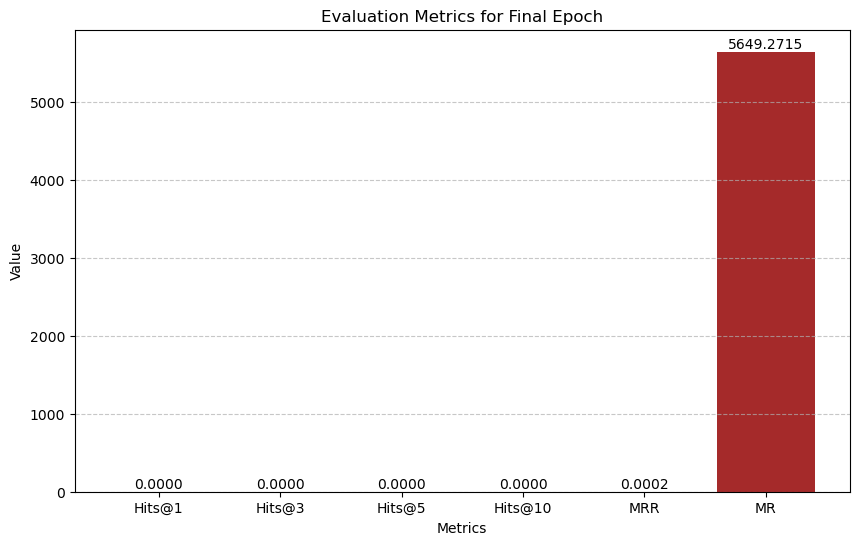

In [9]:
import matplotlib.pyplot as plt
# Extract evaluation metrics from result.metric_results
metric_results = result_transe.metric_results

# Extracting Hits@k values
hits_at_1 = metric_results.get_metric('hits_at_1')
hits_at_3 = metric_results.get_metric('hits_at_3')
hits_at_5 = metric_results.get_metric('hits_at_5')
hits_at_10 = metric_results.get_metric('hits_at_10')

# Extracting MRR and MR
mrr = metric_results.get_metric('mean_reciprocal_rank')
mr = metric_results.get_metric('mean_rank')

# Create lists for metrics and labels
metrics_values = [hits_at_1, hits_at_3, hits_at_5, hits_at_10, mrr, mr]
labels = ['Hits@1', 'Hits@3', 'Hits@5', 'Hits@10', 'MRR', 'MR']

# Plotting the metrics as a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, metrics_values, color=['blue', 'green', 'orange', 'red', 'purple', 'brown'])

# Annotate the value on top of each bar
for bar, value in zip(bars, metrics_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.4f}',
             ha='center', va='bottom', fontsize=10, color='black')

# Labels, title, and grid
plt.xlabel("Metrics")
plt.ylabel("Value")
plt.title("Evaluation Metrics for Final Epoch")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

/tmp/ipykernel_519237/1141896544.py:22: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(pca_result[:, 0], pca_result[:, 1], c='blue', cmap='viridis', s=50, alpha=0.6)


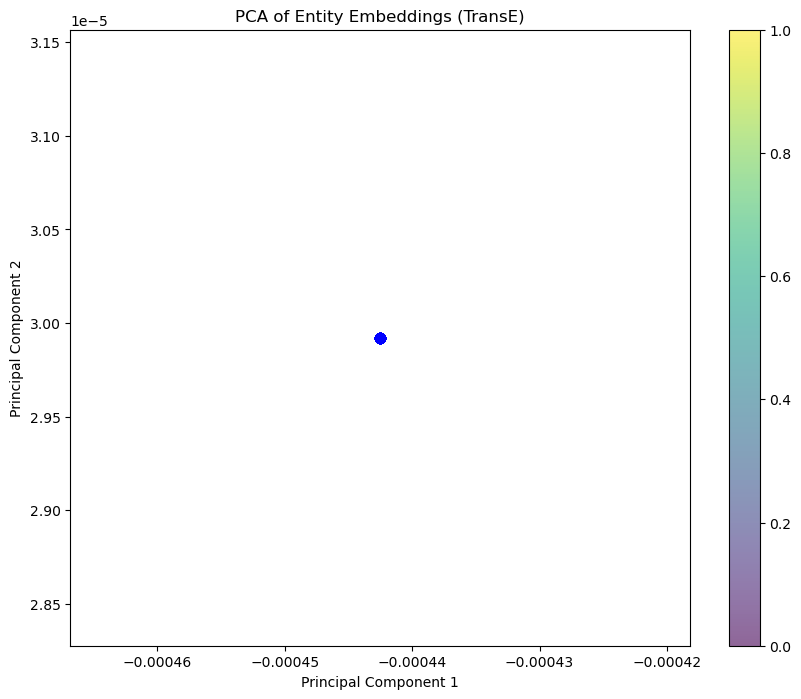

/tmp/ipykernel_519237/1141896544.py:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c='green', cmap='viridis', s=50, alpha=0.6)


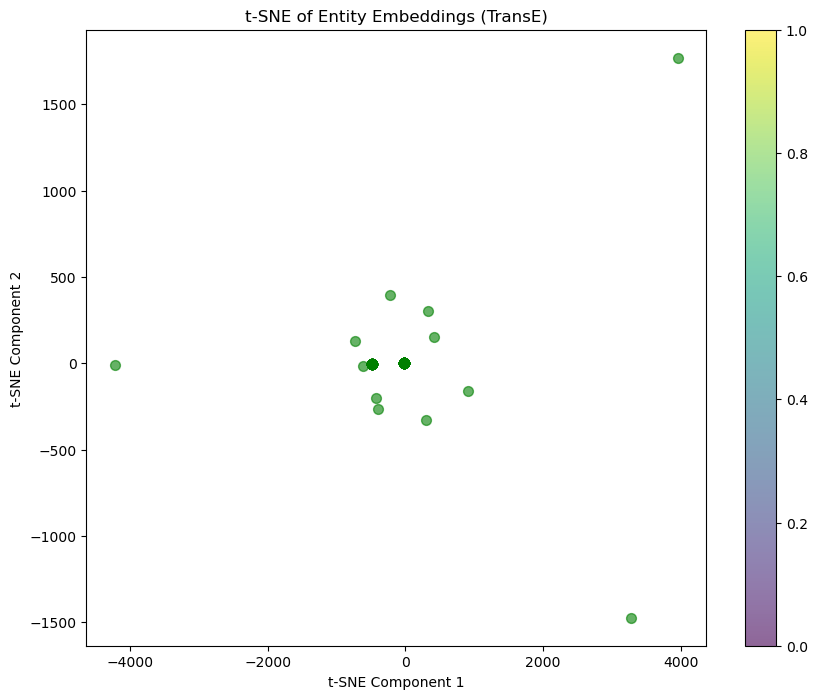

/home/aman24012/miniconda3/envs/aman-24012/lib/python3.10/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import seaborn as sns
import numpy as np

# Step 1: Convert entity embeddings to a NumPy array for further analysis
entity_embeddings_np = entity_embeddings_transe.detach().cpu().numpy()

# Step 2: Perform PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(entity_embeddings_np)

# Step 3: Perform t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(entity_embeddings_np)

# Step 4: Plot the PCA result
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='blue', cmap='viridis', s=50, alpha=0.6)
plt.title('PCA of Entity Embeddings (TransE)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

# Step 5: Plot the t-SNE result
plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c='green', cmap='viridis', s=50, alpha=0.6)
plt.title('t-SNE of Entity Embeddings (TransE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar()
plt.show()

# Step 6: Apply KMeans clustering for Silhouette Score Calculation
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(entity_embeddings_np)

# Step 7: Calculate the Silhouette Score
sil_score = silhouette_score(entity_embeddings_np, cluster_labels)
print(f"Silhouette Score after clustering: {sil_score}")

# === Optional: Print Model Architecture and Parameters ===
print("\nModel Architecture:")
print(trained_model_transe)

print("\nModel Parameters (Weights):")
for name, param in trained_model_transe.named_parameters():
    print(f"{name}: {param.shape}")
    print(param.data[:5])  # Display first 5 elements of each parameter tensor


(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>,
        <Axes: title={'center': 'Entity Plot using PCA'}>], dtype=object))

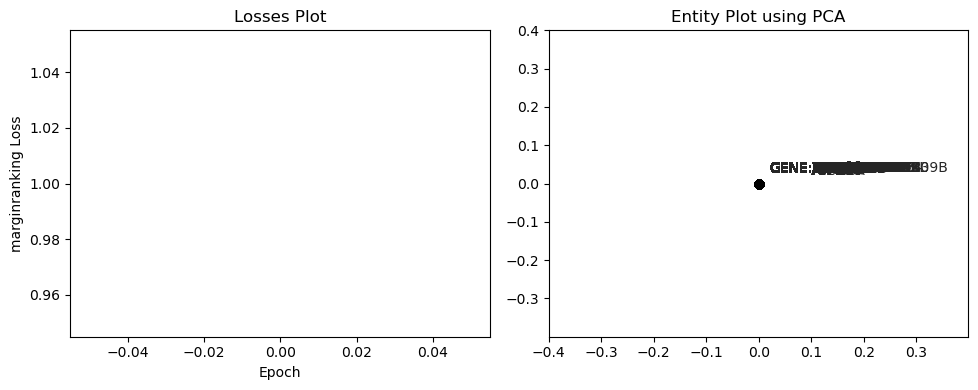

In [13]:
result_transe.plot()

## Message Pasing representation on TransE Model

In [ ]:
import torch
from sklearn.model_selection import train_test_split
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory
import pandas as pd

# Load the triples data from the file (assuming your file is in tab-separated format)
triples_path = 'triples.tsv'  # Replace with your actual triples file path
triples_df = pd.read_csv(triples_path, sep="\t", names=["head", "relation", "tail"])

# === Step 1: Stratified Split by Relation ===
# Split the triples dataframe into train, validation, and test using stratified sampling
train_df, temp_df = train_test_split(
    triples_df, test_size=0.2, stratify=triples_df['relation'], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['relation'], random_state=42
)

# === Step 2: Convert DataFrames to TriplesFactory with Inverse Triples ===
train_tf = TriplesFactory.from_labeled_triples(train_df.values, create_inverse_triples=True)
val_tf = TriplesFactory.from_labeled_triples(val_df.values, create_inverse_triples=True)
test_tf = TriplesFactory.from_labeled_triples(test_df.values, create_inverse_triples=True)

# === Step 3: Define and Run the Pipeline ===
result_CompGCN = pipeline(
    training=train_tf,
    validation=val_tf,
    testing=test_tf,
    model="CompGCN",  # CompGCN uses message passing to update entity representations
    training_kwargs={"num_epochs": 1}
)

# Get the trained model and entity embeddings
trained_model_compgcn = result_CompGCN.model  # Use the correct result name
entity_embeddings_compgcn = trained_model_compgcn.entity_representations[0]()  # Final entity representations

# Print the entity embeddings
print("Entity embeddings from CompGCN:")
print(entity_embeddings_compgcn)



In [9]:
import torch
from sklearn.model_selection import train_test_split
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory
import pandas as pd
from pykeen.nn.init import LabelBasedInitializer

# Import the representation modules.
# Adjust the import paths if needed based on your PyKEEN version.
from pykeen.nn.modules import SimpleMessagePassing, Embedding

# --- Step 1: Load and Split Data ---

# Load triples from a TSV file (adjust the file path as necessary)
triples_path = 'triples.tsv'
triples_df = pd.read_csv(triples_path, sep="\t", names=["head", "relation", "tail"])

# Stratified split based on the relation column
train_df, temp_df = train_test_split(
    triples_df, test_size=0.2, stratify=triples_df['relation'], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['relation'], random_state=42
)

# Convert DataFrames to TriplesFactory objects (with inverse triples)
train_tf = TriplesFactory.from_labeled_triples(train_df.values, create_inverse_triples=True)
val_tf = TriplesFactory.from_labeled_triples(val_df.values, create_inverse_triples=True)
test_tf = TriplesFactory.from_labeled_triples(test_df.values, create_inverse_triples=True)

# --- Step 2: Initialize Embeddings ---

# Create a label-based initializer for entities using the training triples
entity_initializer = LabelBasedInitializer.from_triples_factory(
    triples_factory=train_tf,
    for_entities=True,
)
embedding_dim = entity_initializer.tensor.shape[1]

# --- Step 3: Instantiate Representation Modules ---

# For entities, use SimpleMessagePassing with two GCN layers.
# This module will update the entity embeddings using message passing.
entity_repr = SimpleMessagePassing(
    triples_factory=train_tf,
    base_kwargs=dict(
        shape=embedding_dim,
        initializer=entity_initializer,
        trainable=False,
    ),
    layers=["GCN"] * 2,  # Apply two GCN layers
    layers_kwargs=dict(in_channels=embedding_dim, out_channels=embedding_dim),
)

# For relations, use a simple embedding module.
# Note: Provide num_embeddings equal to the number of relations.
relation_repr = Embedding(
    shape=embedding_dim,
    num_embeddings=train_tf.num_relations,
)

# --- Step 4: Run the Pipeline with TransE ---

result_TransE = pipeline(
    training=train_tf,
    validation=val_tf,
    testing=test_tf,
    model="TransE",  # Use the TransE model
    model_kwargs={
        "entity_representations": entity_repr,
        "relation_representations": relation_repr,
    },
    training_kwargs={"num_epochs": 1},  # Use 1 epoch for demonstration
)

# Retrieve the trained model and final entity embeddings
trained_model_TransE = result_TransE.model
entity_embeddings_TransE = trained_model_TransE.entity_representations[0]()

print("Entity embeddings from TransE with message passing:")
print(entity_embeddings_TransE)


ImportError: cannot import name 'SimpleMessagePassing' from 'pykeen.nn.modules' (/home/aman24012/miniconda3/envs/aman-24012/lib/python3.10/site-packages/pykeen/nn/modules.py)

In [ ]:
## Text Based embeddings

## 3. Text Based embeddings

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from pykeen.triples import TriplesFactory
from pykeen.models import ERModel
from pykeen.nn import TextRepresentation
from pykeen.pipeline import pipeline
from pykeen.datasets import Dataset

# === Data Loading and Splitting ===
triples_path = 'triples.tsv'  # Replace with your actual triples file path
triples_df = pd.read_csv(triples_path, sep="\t", names=["head", "relation", "tail"])
# Remove any rows with missing values in the triples
triples_df = triples_df.dropna(subset=["head", "relation", "tail"])

# Now use the triples_df for the train/test split
train_df, temp_df = train_test_split(
    triples_df, test_size=0.2, stratify=triples_df['relation'], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['relation'], random_state=42
)

# Convert DataFrames to TriplesFactory objects with the identifiers
train_tf = TriplesFactory.from_labeled_triples(train_df.values, create_inverse_triples=False)
val_tf = TriplesFactory.from_labeled_triples(val_df.values, create_inverse_triples=False)
test_tf = TriplesFactory.from_labeled_triples(test_df.values, create_inverse_triples=False)

# Create dataset
dataset = Dataset.from_tf(train_tf)
dataset.validation = val_tf
dataset.testing = test_tf

# === Now use TextRepresentation from PyKEEN ===
entity_representations = TextRepresentation.from_dataset(
    triples_factory=dataset.training,  # Pass only the training set
    encoder="transformer",  # Use transformer-based encoding
)

# === Define and Run the Pipeline ===
result_transe = pipeline(
    dataset=dataset,
    model="TransE",  # Model: TransE (can be replaced with other models like DistMult, ERMLPE, etc.)
    training_kwargs={"num_epochs": 1, "use_tqdm": True},  # Training settings
    model_kwargs=dict(
        entity_representations=entity_representations,  # Pass the entity representations
        embedding_dim=entity_representations.shape[1],  # Set embedding dimension
    ),
)

# === Get the Trained Model and Entity Embeddings ===
trained_model_transe = result_transe.model
entity_embeddings_transe = trained_model_transe.entity_representations[0]()  # Final entity embeddings

# Print the final entity embeddings
print("Entity embeddings from TransE:")
print(entity_embeddings_transe)

In [ ]:
# Extract evaluation metrics from result.metric_results
metric_results = result_transe.metric_results

# Extracting Hits@k values
hits_at_1 = metric_results.get_metric('hits_at_1')
hits_at_3 = metric_results.get_metric('hits_at_3')
hits_at_5 = metric_results.get_metric('hits_at_5')
hits_at_10 = metric_results.get_metric('hits_at_10')

# Extracting MRR and MR
mrr = metric_results.get_metric('mean_reciprocal_rank')
mr = metric_results.get_metric('mean_rank')

# Create lists for metrics and labels
metrics_values = [hits_at_1, hits_at_3, hits_at_5, hits_at_10, mrr, mr]
labels = ['Hits@1', 'Hits@3', 'Hits@5', 'Hits@10', 'MRR', 'MR']

# Plotting the metrics as a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, metrics_values, color=['blue', 'green', 'orange', 'red', 'purple', 'brown'])

# Annotate the value on top of each bar
for bar, value in zip(bars, metrics_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.4f}',
             ha='center', va='bottom', fontsize=10, color='black')

# Labels, title, and grid
plt.xlabel("Metrics")
plt.ylabel("Value")
plt.title("Evaluation Metrics for Final Epoch")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [ ]:
# Step 1: Convert entity embeddings to a NumPy array for further analysis
entity_embeddings_np = entity_embeddings_transe.detach().cpu().numpy()

# Step 2: Perform PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(entity_embeddings_np)

# Step 3: Perform t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(entity_embeddings_np)

# Step 4: Plot the PCA result
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='blue', cmap='viridis', s=50, alpha=0.6)
plt.title('PCA of Entity Embeddings (TransE)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

# Step 5: Plot the t-SNE result
plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c='green', cmap='viridis', s=50, alpha=0.6)
plt.title('t-SNE of Entity Embeddings (TransE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar()
plt.show()

# Step 6: Apply KMeans clustering for Silhouette Score Calculation
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(entity_embeddings_np)

# Step 7: Calculate the Silhouette Score
sil_score = silhouette_score(entity_embeddings_np, cluster_labels)
print(f"Silhouette Score after clustering: {sil_score}")

# === Optional: Print Model Architecture and Parameters ===
print("\nModel Architecture:")
print(trained_model_transe)

print("\nModel Parameters (Weights):")
for name, param in trained_model_transe.named_parameters():
    print(f"{name}: {param.shape}")
    print(param.data[:5])  # Display first 5 elements of each parameter tensor


In [ ]:
result_transe.plot()